# Exploring time series in python

**Date started**: 21st June 2022

**Guide**: https://rishi-a.github.io/2020/05/25/granger-causality.html

**Factors to consider altering/adding**: 
* Normalisation
* Transformation (log)
* Checking all VAR fit stats
* Lag

In [1]:
# Inputs
shift_lag = -0*7
forecast_steps = 30
log_prevalence = True # remove once prev removed
granger_lag=14

print('INPUTS USED:\n')
print(f'- Lag used is {shift_lag} days\n')
print(f'- Forecasting ahead {forecast_steps} days\n')
if (log_prevalence==True):
    print("- Logged prevalence data is used")
else:
    print("- Non-logged prevalence data is used")

INPUTS USED:

- Lag used is 0 days

- Forecasting ahead 30 days

- Logged prevalence data is used


In [65]:
# Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from datetime import timedelta
import statsmodels
import statsmodels.tsa.stattools as smt
from statsmodels.tsa.api import VAR
from dateutil.relativedelta import relativedelta
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import JohansenTestResult
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import grangercausalitytests
import sklearn
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.stats.stattools import durbin_watson

In [3]:
# # Use this to install any packages required in general:

# import subprocess
# import sys

# def install(package):
#    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    
# install("statsmodels")

In [4]:
# Setting plot sizes
plt.rcParams["figure.figsize"] = (12,9)

In [5]:
# Useful dates

lockdown_1_start = dt.datetime.strptime("2020-03-26","%Y-%m-%d")
lockdown_1_end = dt.datetime.strptime("2020-06-15","%Y-%m-%d")

lockdown_2_start = dt.datetime.strptime("2020-11-05","%Y-%m-%d")
lockdown_2_end = dt.datetime.strptime("2020-12-02","%Y-%m-%d")

lockdown_3_start = dt.datetime.strptime("2021-01-06","%Y-%m-%d")
lockdown_3_end = dt.datetime.strptime("2021-04-21","%Y-%m-%d")

REACT_start = dt.datetime.strptime("2020-05-01","%Y-%m-%d")

start_date = lockdown_3_start
end_date = lockdown_3_end

print(f'Start date is: {start_date}, i.e. start of lockdown 3')
print(f'End date is: {end_date}, i.e. end of lockdown 3')

Start date is: 2021-01-06 00:00:00, i.e. start of lockdown 3
End date is: 2021-04-21 00:00:00, i.e. end of lockdown 3


## Time Series

Exploring Granger Causality using tutorial - https://rishi-a.github.io/2020/05/25/granger-causality.html

In [6]:
# Loading data

mob_long = pd.read_csv("/Users/elliebloom/Desktop/Masters/Project/Analysis/Mapping/Outputs/google_regional_long.csv", index_col='date',parse_dates=['date'])
mob_wide = pd.read_csv("/Users/elliebloom/Desktop/Masters/Project/Analysis/Mapping/Outputs/google_regional_wide.csv", index_col='date',parse_dates=['date'])
prev = pd.read_csv("/Users/elliebloom/Desktop/Masters/Project/Analysis/Time_series_analysis/Ouputs/Tibbles/prev_smooth_tibble.csv", index_col='d_comb',parse_dates=['d_comb'])

# Adding in reproduction number instead of prevalence
reprod = pd.read_csv("/Users/elliebloom/Desktop/Masters/Project/Data/REACT_reproduction/National_reproduction_R.csv", index_col='d_comb',parse_dates=['d_comb'])


mob_long.index = pd.to_datetime(mob_long.index)
mob_wide.index = pd.to_datetime(mob_wide.index)
mob_wide = mob_wide.sort_index()
reprod = reprod.sort_index()

# Using log prevalence if specified
if(log_prevalence==True):
    prev['p']=np.log(prev['p'])

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


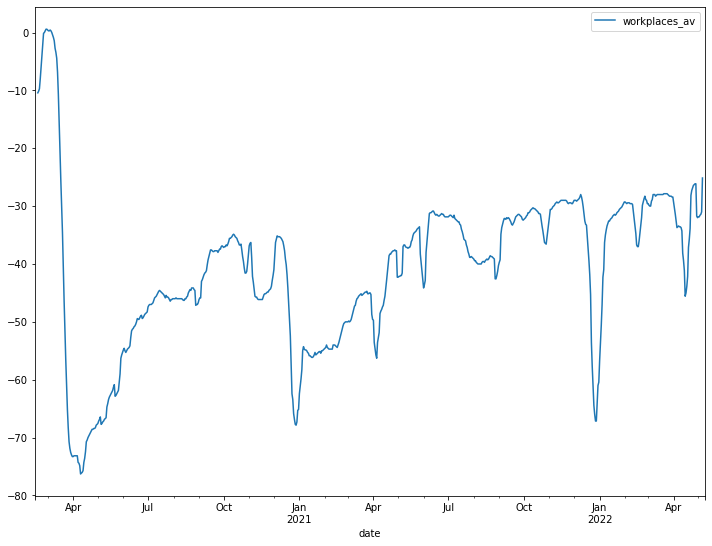

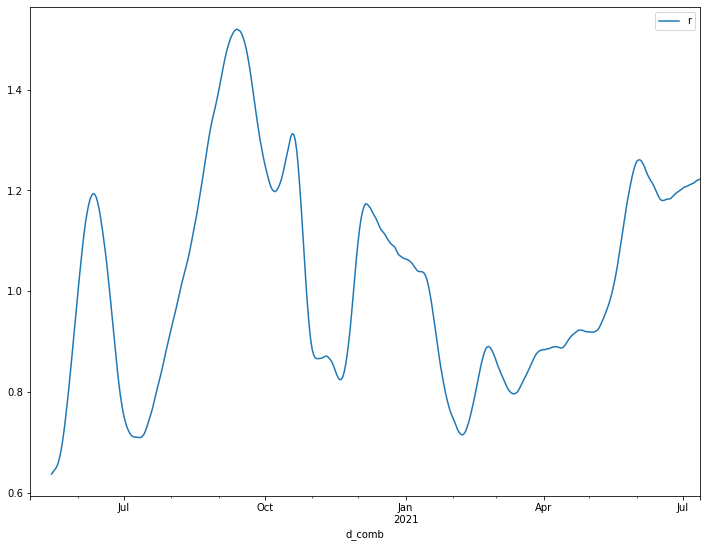

In [7]:
# Focusing on England - NOTE THAT MOBILITY IS FOR LONDON RIGHT NOW - CHANGE ONCE HAVE THE RIGHT 7-DAY AV
mob_england = mob_wide[mob_wide['region']=="LONDON"]
reprod_england = reprod


# Only including columns of interest
mob_england = mob_england[['workplaces_av']]
reprod_england = reprod_england[['r']]

# Plots over whole period of data
print(mob_england.plot())
print(reprod_england.plot())

# Note not yet restricted the dates yet at this point

In [8]:
mob_england.head()

workplaces_av
date                     
2020-02-15            NaN
2020-02-16            NaN
2020-02-17            NaN
2020-02-18     -10.428571
2020-02-19     -10.142857

In [9]:
# Shifting by specified lag - as calculated by CCF of log(prev) vs mobility

# print(f'Lag used is {shift_lag} days')
# mob_london['workplaces_av']=mob_london['workplaces_av'].shift(shift_lag)

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


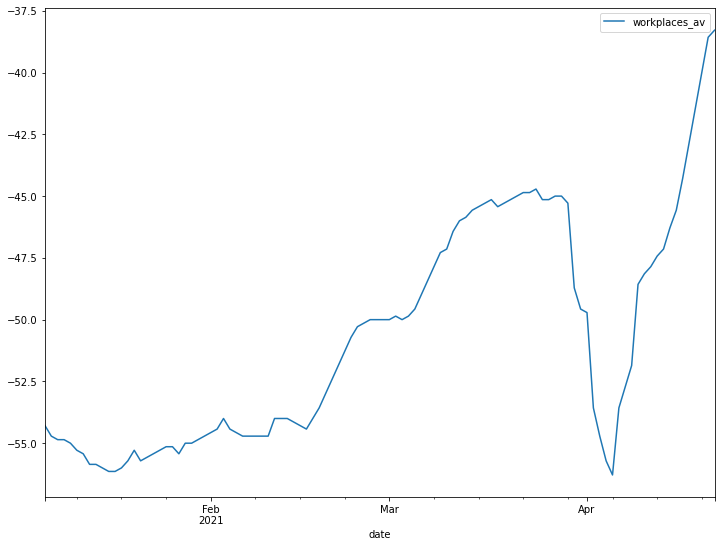

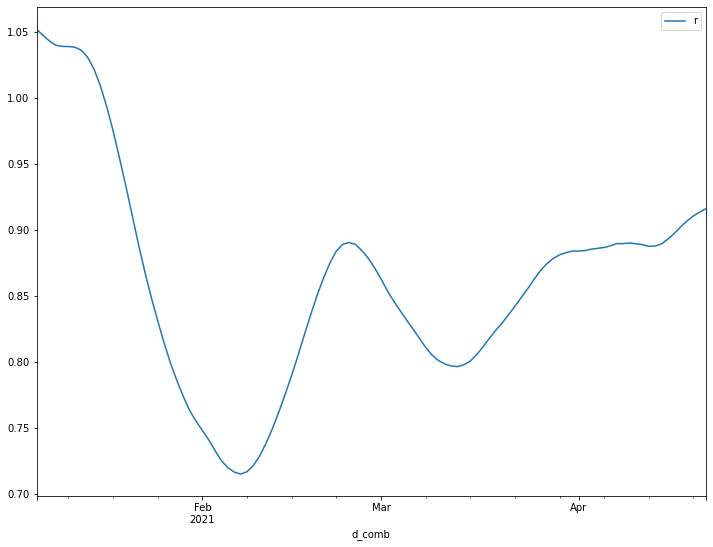

In [10]:
# Focussing on specified interval
mob_england = mob_england.loc[start_date:end_date]
reprod_england = reprod_england.loc[start_date:end_date]
print(mob_england.plot())
print(reprod_england.plot())

# mob_london and prev_london are now restricted by date

In [11]:
# Merging into a combined England dataframe
england = pd.merge(mob_england, reprod_england, how='inner', left_index=True, right_index=True)
# london dataframe starts at the start_date and ends at the end_date

In [12]:
# NO LONGER NEEDED

# Removing the columns that aren't needed
#london = london[['workplaces_av','p']]
#london.tail()

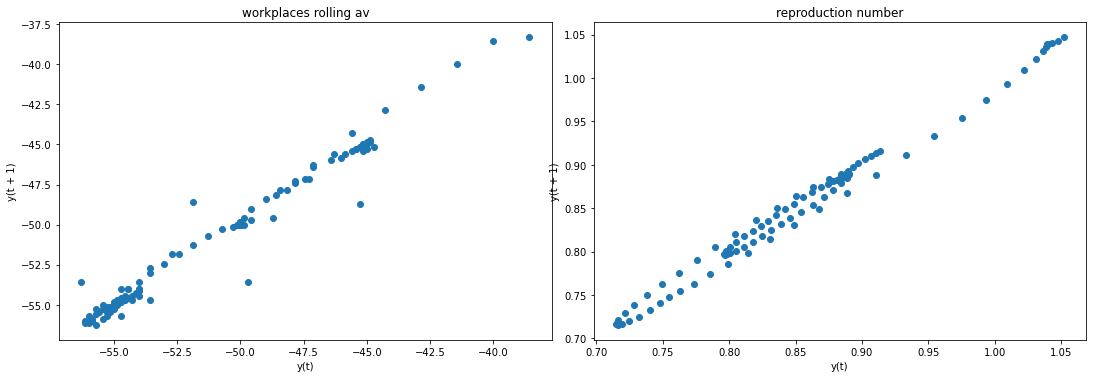

In [13]:
# Plotting yt vs yt+1 to investigate autocorrelation
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(england['workplaces_av'], ax=ax4)
ax4.set_title('workplaces rolling av');

lag_plot(england['r'], ax=ax5)
ax5.set_title('reproduction number');

In [14]:
# Making a copy of the data prior to differencing
raw_england = england.copy(deep=True)

# raw_london is undifferenced and dates are restricted between start_date and end_date

In [15]:
# Differencing - differencing required for both rolling av mobility and log prevalence

england['workplaces_av'] = england['workplaces_av'] - england['workplaces_av'].shift(1)
england['r'] = england['r'] - england['r'].shift(1)
england = england.dropna()

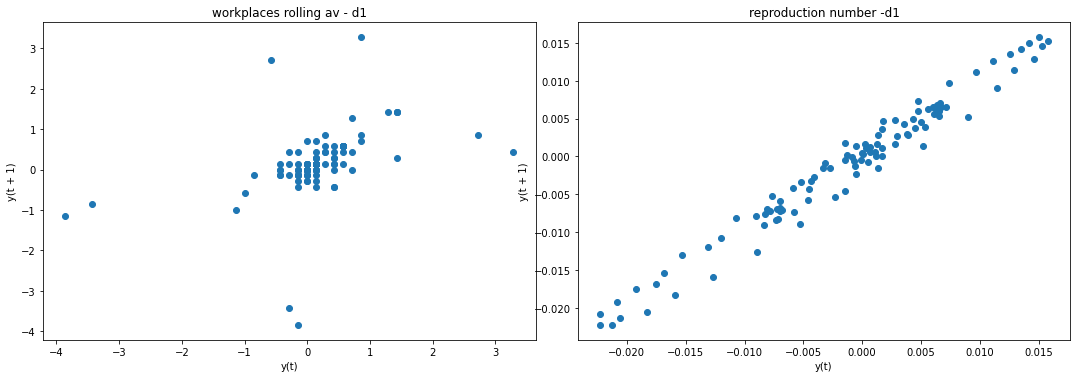

In [16]:
# Plots after differencing once

f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(england['workplaces_av'], ax=ax4)
ax4.set_title('workplaces rolling av - d1');

lag_plot(england['r'], ax=ax5)
ax5.set_title('reproduction number -d1');

In [17]:
# There is still clear autocorrelation for reprod so difference this once again
england['r'] = england['r'] - england['r'].shift(1)
england = england.dropna()

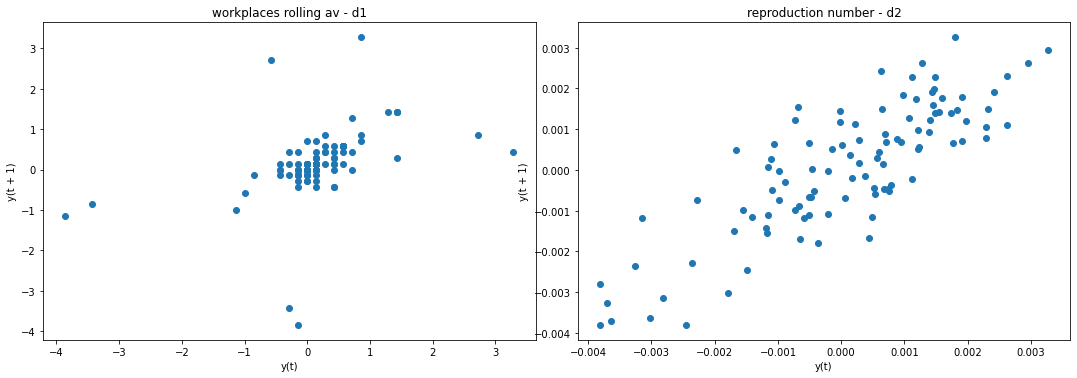

In [18]:
# Plotting again
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(england['workplaces_av'], ax=ax4)
ax4.set_title('workplaces rolling av - d1');

lag_plot(england['r'], ax=ax5)
ax5.set_title('reproduction number - d2');

In [19]:
# Differencing prevalence again

# There is still clear autocorrelation for prevalence so shift this once again
england['r'] = england['r'] - england['r'].shift(1)
england = england.dropna()
england.head()

workplaces_av         r
date                               
2021-01-09       0.000000  0.000897
2021-01-10      -0.142857  0.001169
2021-01-11      -0.285714 -0.001508
2021-01-12      -0.142857 -0.001146
2021-01-13      -0.428571 -0.001427

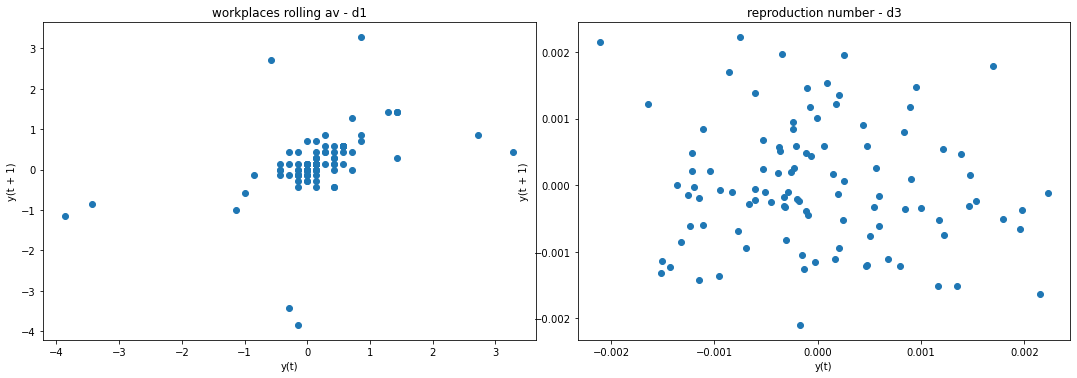

In [20]:
# Plotting again
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(england['workplaces_av'], ax=ax4)
ax4.set_title('workplaces rolling av - d1');

lag_plot(england['r'], ax=ax5)
ax5.set_title('reproduction number - d3');

In [21]:
# Try one more differencing...

Looks ok now - so mobility is differenced once, prevalence 3 times. Next to statistically test that these are stationary

In [22]:
## ADF Null hypothesis: there is a unit root, meaning series is non-stationary

# Checking stationarity of differenced data with restricted date between start_date and end_date

X1 = np.array(england['workplaces_av'])
X1 = X1[~np.isnan(X1)]

ADF_mob = adfuller(X1)
print('ADF Statistic: %f' % ADF_mob[0])
print('p-value: %f' % ADF_mob[1])
if (ADF_mob[1]<0.05): print('Mobility is stationary as p<0.05')
if (ADF_mob[1]>0.05): print('Mobility is non-stationary as p>0.05')
print('Critical Values:')
for key, value in ADF_mob[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
ADF_mob_t = ADF_mob[0]
ADF_mob_p = ADF_mob[1]    
    
X2 = np.array(england['r'])
X2 = X2[~np.isnan(X2)]

ADF_prev = adfuller(X2)
print('ADF Statistic: %f' % ADF_prev[0])
print('p-value: %f' % ADF_prev[1])
if (ADF_prev[1]<0.05): print('Reprod is stationary as p<0.05')
if (ADF_prev[1]>0.05): print('Reprod is non-stationary as p>0.05')
print('Critical Values:')
for key, value in ADF_prev[4].items():
    print('\t%s: %.3f' % (key, value))
    
ADF_prev_t = ADF_prev[0]
ADF_prev_p = ADF_prev[1] 

ADF Statistic: -3.147141
p-value: 0.023256
Mobility is stationary as p<0.05
Critical Values:
	1%: -3.505
	5%: -2.894
	10%: -2.584
ADF Statistic: -11.051003
p-value: 0.000000
Reprod is stationary as p<0.05
Critical Values:
	1%: -3.496
	5%: -2.890
	10%: -2.582


In [23]:
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary

from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

KPSS_mob_stat = kpss(X1)[0]
KPSS_mob_p = kpss(X1)[1]

KPSS_prev_stat = kpss(X2)[0]
KPSS_prev_p = kpss(X2)[1]
    
kpss_test(X1)
kpss_test(X2)

# now stationary

KPSS Statistic: 0.1639719293665988
p-value: 0.1
num lags: 4
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
KPSS Statistic: 0.031966511824057506
p-value: 0.1
num lags: 1
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/Users/elliebloom/miniforge3/envs/env_tensor/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/elliebloom/miniforge3/envs/env_tensor/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/elliebloom/miniforge3/envs/env_tensor/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/elliebloom/miniforge3/envs/env_tensor/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWar

Overall result to far -  both stationary:  
* Mobility - d=1
* Reprod - logged, d=3

In [25]:
# split data into train and test. We will need this later for VAR analysis

# Considering if seeding in this way is the most appropriate - https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f
np.random.seed(5)
msk = np.random.rand(len(england)) < 0.8
train = england[msk]
test = england[~msk]

# Note train and test are using the differenced data, restricted from start_date to end_date

Result: lag plot is confirmatory with ADF test and KPSS. Uses moving average and 3 differences

Next: setting up VAR model

**Step 2**: Let the maximum order of integration for the group of time-series be d. So, if there are two time-series and one is found to be I(1) and the other is I(2), then d = 2. If one is I(0) and the other is I(1), then m = 1, etc.

**Result**: Saw above that in this case d=1

**Step 3**: Set up a VAR model in the levels of the data, regardless of the orders of integration of the various time-series. Most importantly, **you must not difference the data, no matter what you found at Step 1**.

**Step 4**: Determine the appropriate maximum lag length for the variables in the VAR, say p, using the usual methods. Specifically, base the choice of p on the usual information criteria, such as AIC, SIC.


**Note**: try running like this first, then incorporate info on the lag later


In [ ]:
# Trying cross-validation for model selection instead

In [26]:
raw_england.head()

workplaces_av         r
date                               
2021-01-06     -54.285714  1.051937
2021-01-07     -54.714286  1.047405
2021-01-08     -54.857143  1.043094
2021-01-09     -54.857143  1.039902
2021-01-10     -55.000000  1.038997

In [27]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
from sklearn.model_selection import TimeSeriesSplit

In [30]:
# https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/

class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [38]:
raw_england = raw_england.dropna()

res_dict_cv = {'Lag': [],'MAE': [], 'MSE':[], 'MAPE':[]}

tscv = BlockingTimeSeriesSplit(n_splits=5)

In [44]:
# # Lengths are a bit small
# # Would be good to extend the forecast to beyond 7 and extend the test size

# for train_index, test_index in tscv.split(raw_england):
#     for i in range(1,13):
#         print(f"Train:{train_index}")
#         print(f"Test:{test_index}")
#         train = raw_england.iloc[train_index]
#         test = raw_england.iloc[test_index]
#         model = VAR(train)
#         result = model.fit(i)
#         lagged_values = train.values[-i:]
#         pred = result.forecast(y=lagged_values, steps=test.shape[0]) 
#         pred_england = pred[:,1]
#         actual_reprod = test.values[:,1]
#         res_dict_cv['Lag'].append(i)
#         res_dict_cv['MAE'].append(metrics.mean_absolute_error(actual_reprod, actual_reprod))
#         res_dict_cv['MSE'].append(metrics.mean_squared_error(actual_reprod, actual_reprod))
#         res_dict_cv['MAPE'].append(metrics.mean_squared_error(actual_reprod, actual_reprod))

# res_dict_cv
       
# model_result_cv = pd.DataFrame(res_dict_cv)

In [45]:
# model_result_cv.tail()

In [46]:
# res_dict = {'Lag': [],'MAE_mean': [], 'MAE_sd':[], 'MSE_mean':[], 'MSE_sd':[], 'MAPE_mean':[],'MAPE_sd':[]}

# for i in range(1,13):
#     result_lag = model_result_cv[model_result_cv['Lag']==i]
#     res_dict['Lag'].append(i)
#     res_dict['MAE_mean'].append(np.mean(result_lag['MAE']))
#     res_dict['MAE_sd'].append(np.std(result_lag['MAE']))
#     res_dict['MSE_mean'].append(np.mean(result_lag['MSE']))
#     res_dict['MSE_sd'].append(np.std(result_lag['MSE']))
#     res_dict['MAPE_mean'].append(np.mean(result_lag['MAPE']))
#     res_dict['MAPE_sd'].append(np.std(result_lag['MAPE']))
       

In [ ]:
# model_result = pd.DataFrame(res_dict)
# model_result

In [ ]:
# print(f"The lag that minimises the MAE is: {np.argmin(model_result['MAE_mean'])+1}")
# print(f"The lag that minimises the MSE is: {np.argmin(model_result['MSE_mean'])+1}")
# print(f"The lag that minimises the MAPE is: {np.argmin(model_result['MAPE_mean'])+1}")

# lag_order = np.argmin(model_result['MAE_mean'])+1
# lag_order_MSE = np.argmin(model_result['MSE_mean'])+1
# lag_order_MAPE = np.argmin(model_result['MAPE_mean'])+1

In [ ]:
# model = VAR(np.asarray(london))
# model_fitted = model.fit(lag_order)
# Note this is now using the differened data within the restricted dates

In [ ]:
# obtain the lag P for VAR

# raw_london = raw_london.dropna()
# model = VAR(np.array(raw_london)) #recall that rawData is w/o difference operation
# raw_london.tail()

# raw_london is undifferenced and dates are restricted between start_date and end_date

In [ ]:
# res_dict = {'Lag': [],'AIC': [], 'BIC':[], 'FPE':[], 'HQIC': []}
# for i in range(1, 13):
#     result = model.fit(i)
#     res_dict['Lag'].append(i)
#     res_dict['AIC'].append(result.aic)
#     res_dict['BIC'].append(result.bic)
#     res_dict['FPE'].append(result.fpe)
#     res_dict['HQIC'].append(result.hqic)
    
# model_result = pd.DataFrame(res_dict)
# model_result

In [ ]:
# print(f"The lag that minimises the AIC is: {np.argmin(model_result['AIC'])+1}")
# print(f"The lag that minimises the BIC is: {np.argmin(model_result['BIC'])+1}")
# print(f"The lag that minimises the FPE is: {np.argmin(model_result['FPE'])+1}")
# print(f"The lag that minimises the HQIC is: {np.argmin(model_result['HQIC'])+1}")

**Result**: The lag order p=8 on the basis of AIC  
**Step 5**: Make sure that the VAR is well-specified. For example, ensure that there is no serial correlation in the residuals. If need be, increase p until any autocorrelation issues are resolved.

In [ ]:
# # Using AIC as the criteria
# lag_order = np.argmin(model_result['AIC'])+1
# lag_order_BIC = np.argmin(model_result['BIC'])+1
# lag_order_FPE = np.argmin(model_result['FPE'])+1
# lag_order_HQIC = np.argmin(model_result['HQIC'])+1
# print(f"Lag used based on minising the AIC is:{lag_order}")

# model = VAR(np.asarray(train))
# model_fitted = model.fit(lag_order) 

# # Note train and test are using the differenced data, restricted from start_date to end_date

In [ ]:
#Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
#The value of this statistic can vary between 0 and 4. 
#The closer it is to the value 2, then there is no significant serial correlation. 
#The closer to 0, there is a positive serial correlation, 
#and the closer it is to 4 implies negative serial correlation.

out = durbin_watson(model_fitted.resid)

for col, val in zip(london.columns, out):
    print(col, ':', round(val, 2))

resid_corr_mob = out[0]
resid_corr_prev = out [1]

**Result**: There is no significant correlation between in the residuals

**Step 6**: If two or more of the time-series have the same order of integration, at Step 1, then test to see if they are cointegrated, preferably using Johansen’s methodology (based on your VAR) for a reliable result.  

**Johansen's test**:   
H0: There are no cointegrating equations 

In [ ]:
# Function from here : http://web.pdx.edu/~crkl/ceR/Python/example14_3.py

"""
    Johansen cointegration test of the cointegration rank of a VECM

    Parameters
    ----------
    endog : array_like (nobs_tot x neqs)
        Data to test
    det_order : int
        * -1 - no deterministic terms - model1
        * 0 - constant term - model3
        * 1 - linear trend
    k_ar_diff : int, nonnegative
        Number of lagged differences in the model.
"""



def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Series 0 is mobility")
    print("Series 1 is prevalence\n")
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')
    
    if (res.lr2[0]>res.cvm[0][1]): 
        print('Mobility series cointegrates using eigenvalue method at 95% level')
    else:
        print('Mobility series does not cointegrate using eigenvalue method at 95% level')
        
    if (res.lr2[0]>res.cvt[0][1]): 
        print('Mobility series cointegrates using trace method at 95% level')
    else:
        print('Mobility series does not cointegrate using trace method at 95% level')  
        
    if (res.lr1[1]>res.cvm[1][1]): 
        print('Prevalence series cointegrates using eigenvalue method at 95% level')
    else:
        print('Prevalence series does not cointegrate using eigenvalue method at 95% level')
    
    if (res.lr2[1]>res.cvt[1][1]): 
        print('Prevalence series cointegrates using trace method at 95% level')
    else:
        print('Prevalence series does not cointegrate using trace method at 95% level')  

        
result = coint_johansen(np.asarray(raw_london),0,1)
joh_output(result)


johansen_eigenvalue_mob =result.lr2[0]
johansen_trace_mob= result.lr1[0]
johansen_eigenvalue_prev = result.lr2[1]
johansen_trace_prev=result.lr1[1]
johansen_eignvalue_95_mob = result.cvm[0][1]
johansen_eignvalue_95_prev =  result.cvm[1][1]
johansen_trace_95_mob = result.cvt[0][1]
johansen_trace_95_prev = result.cvt[1][1]



# raw_london is undifferenced and dates are restricted between start_date and end_date

**Result**: Greater than all critical values, thus p<0.05 - Thus rejecting the null hypothesis. Thus they are cointegrated.

In [ ]:
# Trying the other test done in the tutorial
# This uses the augmented Engle-Granger two-step cointegration test. Constant or trend is included in 1st stage regression, i.e. in cointegrating equation.

result=ts.coint(london['workplaces_av'], london['p'], return_results=True) # note using the differenced data
print(result)

if (result[1]<0.05):
    print("The two time series are cointegrated (p<0.05)")
else:
    print("The two time series are NOT cointegrated (p>0.05)")

# Note the results includes: t stat, p value, [1% critical value, 5% critical value, 10% critical value]

# Why use the differenced data here and not elsewhere? Note this test is not significant when using the raw non-differentiated data - NEED TO FIGURE THIS OUT!!

**Result** : The p-values < 0.05. Thus now rejecting the null hypothesis. Thus they are cointegrated using this alternative test too.

**Step 7**: No matter what you conclude about cointegration at Step 6, this is not going to affect what follows. It just provides a possible cross-check on the validity of your results at the very end of the analysis.  
**Step 8**: Now take the preferred VAR model and add in m additional lags of each of the variables into each of the equations.  

In [ ]:
# Model previously fitted like this - what does it mean add it an additional m lags?
#model = VAR(np.asarray(train))
#model_fitted = model.fit(lag_order)

# WHAT DOES THIS EXTRA LAGS BIT MEAN??


In [66]:
statsmodels.__version__

# Should be able to specify range of lags e.g could try 25:35?:
# https://github.com/statsmodels/statsmodels/issues/6618
# Look into this!!

'0.13.2'

**Step 9 and Step 10**: Test for Granger non-causality. It’s essential that you don’t include the coefficients for the ‘extra’ m lags when you perform the tests. They are there just to fix up the asymptotics.

**Granger causality test using variable lag from VAR**

^ I'm not sure I've done step 8 right, and not sure what it means by the 'extra' lags above? Should add them in later?

In [68]:
# Choosing an arbitrary lag order for now
lag_order = 25


maxlag=lag_order #becuase we got this value before. We are not suppose to add 1 to it

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

granger_variable = grangers_causation_matrix(england, variables = train.columns)  

In [62]:
print(granger_variable)
print("\n")

if(granger_variable.iloc[0,1]<0.05):
    print(f"Reprod granger causes mobility (using VAR lag of {lag_order}) as p<0.05 (p={granger_variable.iloc[0,1]})\n")
else:
    print(f"Reprod does NOT granger causes mobility (using VAR lag of {lag_order}) as p>0.05 (p={granger_variable.iloc[0,1]})\n")
    
if(granger_variable.iloc[1,0]<0.05):
    print(f"Mobility granger causes reprod (using VAR lag of {lag_order}) as p<0.05 (p={granger_variable.iloc[1,0]})")
else:
    print(f"Mobility does NOT granger causes reprod (using VAR lag of {lag_order}) as p>0.05 (p={granger_variable.iloc[1,0]})")

    
granger_p_mob_reprod_variable = granger_variable.iloc[1,0]
granger_p_reprod_mob_variable = granger_variable.iloc[0,1]

print(granger_p_mob_reprod_variable)
print(granger_p_reprod_mob_variable)


                 workplaces_av_x     r_x
workplaces_av_y            1.000  0.0496
r_y                        0.001  1.0000


Reprod granger causes mobility (using VAR lag of 25) as p<0.05 (p=0.0496)

Mobility granger causes reprod (using VAR lag of 25) as p<0.05 (p=0.001)
0.001
0.0496


**Granger causality test with fixed lag of 14**

In [ ]:

maxlag=granger_lag #becuase we got this value before. We are not suppose to add 1 to it

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

granger_fixed = grangers_causation_matrix(london, variables = train.columns)  

In [ ]:
print(granger_fixed)
print("\n")

if(granger_fixed.iloc[0,1]<0.05):
    print(f"Prevalence granger causes mobility (using fixed lag of 14) as p<0.05 (p={granger_fixed.iloc[0,1]})\n")
else:
    print(f"Prevalence does NOT granger causes mobility (using fixed lag of 14) as p>0.05 (p={granger_fixed.iloc[0,1]})\n")
    
if(granger_fixed.iloc[1,0]<0.05):
    print(f"Mobility granger causes prevalence (using fixed lag of 14) as p<0.05 (p={granger_fixed.iloc[1,0]})")
else:
    print(f"Mobility does NOT granger causes prevalence (using fixed lag of 14) as p>0.05 (p={granger_fixed.iloc[1,0]})")

    
granger_p_mob_prev_fixed = granger_fixed.iloc[1,0]
granger_p_prev_mob_fixed = granger_fixed.iloc[0,1]

      
**Result**: If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row). 

**Step 11**: Finally, look back at what you concluded in Step 6 about cointegration.  

If two or more time-series are cointegrated, then there must be Granger causality between them - either one-way or in both directions. However, the converse is not true.

So, if your data are cointegrated but you don't find any evidence of causality, you have a conflict in your results. (**This might occur if your sample size is too small to satisfy the asymptotics that the cointegration and causality tests rely on.**) If you have cointegration and find one-way causality, everything is fine. (You may still be wrong about there being no causality in the other direction.) If your data are not cointegrated, then you have no cross-check on your causality results.


**Now diverging from the tutorial, exploring forecasting**

In [ ]:
# Exploring forecasting

# Firstly summary of the model
model_fitted.summary()
# y1  = mobility
# y2 = prevalence

**Result**: None of the coefficients are significant for mobility (y1) for the equation for y2 (prevalence). However, nor are any of the prevalence ones either??

In [ ]:
# Forecasting ahead
# https://www.analyticsvidhya.com/blog/2021/08/vector-autoregressive-model-in-python/

lagged_Values = london.values[-lag_order:] # london is the differenced data, restricted between start_date and end_date
pred = model_fitted.forecast(y=lagged_Values, steps=forecast_steps) 

In [ ]:
# Tidying this up into a dataframe with dates
pred = pd.DataFrame(data=pred,columns=['workplaces_av_pred','p_pred'])
days = pd.date_range(np.max(raw_london.index)+relativedelta(days=1), np.max(raw_london.index) + timedelta(forecast_steps), freq='D')
pred['date']=days
pred = pred.set_index('date')
print(pred.head(10))
pred.tail(50)

# case see that the differences for both converge??


In [ ]:
# Adding this onto the original dataframe and creating separate dataframes for mobility and prevalence
merged_data = pd.concat([london,pred])
data_prev = merged_data.drop(['workplaces_av_pred', 'workplaces_av'], axis=1)
data_mob = merged_data.drop(['p_pred', 'p'], axis=1)

# Reversing the differencing

### Mobility

In [ ]:
london_data = mob_wide[mob_wide['region']=="LONDON"]
london_data = london_data[['workplaces_av']]
london_data.rename(columns = {'workplaces_av':'workplaces_av_undiff'}, inplace = True)

# london_data is undifferenced and unrestricted by date

In [ ]:
london_forecast=pd.concat([london_data, data_mob], axis=1)
forecast_start_date = end_date+relativedelta(days=1)
forecast_end_date =  end_date+relativedelta(days=forecast_steps)
london_forecast = london_forecast.loc[start_date:forecast_end_date]

In [ ]:
london_forecast['diff_cum_sum'] = london_forecast['workplaces_av_pred'].cumsum()
london_forecast['workplaces_av_pred_undiff']=np.nan
london_forecast['workplaces_av_pred_undiff'].loc[end_date] = london_forecast['workplaces_av_undiff'].loc[end_date]+london_forecast['diff_cum_sum'].loc[end_date+relativedelta(days=1)]

for i in range(1,forecast_steps,1):
    london_forecast['workplaces_av_pred_undiff'].loc[end_date+relativedelta(days=i)]=london_forecast['workplaces_av_pred_undiff'].loc[end_date]+london_forecast['diff_cum_sum'].loc[end_date+relativedelta(days=i+1)]

    
london_forecast.tail(31)   


In [ ]:
london_forecast = london_forecast[['workplaces_av_undiff','workplaces_av_pred_undiff']]
london_forecast.rename(columns = {'workplaces_av_undiff':'workplace_mobility_actual','workplaces_av_pred_undiff':'workplace_mobility_pred'}, inplace = True)
london_forecast.plot()

# True data in blue
# Forecast in orange

In [ ]:
# Metrics:
#https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

true_mob = london_forecast['workplace_mobility_actual'].loc[forecast_start_date:forecast_end_date+relativedelta(days=-1)] # -1 days required as final element is NaN
pred_mob = london_forecast['workplace_mobility_pred'].loc[forecast_start_date:forecast_end_date+relativedelta(days=-1)]

MAE_mob = metrics.mean_absolute_error(true_mob, pred_mob)
MSE_mob = metrics.mean_squared_error(true_mob, pred_mob)
MAPE_mob = metrics.mean_absolute_percentage_error(true_mob, pred_mob)

print(f"MAE: {np.round(MAE_mob,3)}")
print(f"MSE: {np.round(MSE_mob,3)}")
print(f"MAPE: {np.round(MAPE_mob,4)*100}%")

## Prevalence

In [ ]:
prev_london = prev[prev['region']=='LONDON']
prev_london = prev_london[['p']]
prev_london.rename(columns = {'p':'p_undiff'},inplace= True)
prev_london=pd.concat([prev_london, data_prev], axis=1)

In [ ]:
prev_forecast = prev_london.loc[start_date:forecast_end_date]

In [ ]:
# Cumulative sum three times as differenced three times
prev_forecast['undiff1_cum_sum'] = prev_forecast['p_pred'].cumsum()
prev_forecast['undiff2_cum_sum'] = prev_forecast['undiff1_cum_sum'].cumsum()
prev_forecast['undiff3_cum_sum'] = prev_forecast['undiff2_cum_sum'].cumsum()

In [ ]:
prev_forecast['p_pred_undiff']=np.nan
prev_forecast['p_pred_undiff'].loc[end_date] = prev_forecast['p_undiff'].loc[end_date]+prev_forecast['undiff3_cum_sum'].loc[end_date+relativedelta(days=1)]
prev_forecast['undiff3_cum_sum'].loc[end_date+relativedelta(days=1)]

for i in range(1,forecast_steps,1):
    prev_forecast['p_pred_undiff'].loc[end_date+relativedelta(days=i)]=prev_forecast['p_pred_undiff'].loc[end_date]+prev_forecast['undiff3_cum_sum'].loc[end_date+relativedelta(days=i+1)]

    
prev_forecast.tail(31)  

In [ ]:
prev_forecast = prev_forecast[['p_undiff','p_pred_undiff']]
prev_forecast.rename(columns = {'p_undiff':'prevalence_actual','p_pred_undiff':'prevalence_pred'}, inplace = True)
prev_forecast.plot()

In [ ]:
# Metrics

true_prev = prev_forecast['prevalence_actual'].loc[forecast_start_date:forecast_end_date+relativedelta(days=-1)]
pred_prev = prev_forecast['prevalence_pred'].loc[forecast_start_date:forecast_end_date+relativedelta(days=-1)]

MAE_prev = metrics.mean_absolute_error(true_prev, pred_prev)
MSE_prev = metrics.mean_squared_error(true_prev, pred_prev)
MAPE_prev = metrics.mean_absolute_percentage_error(true_prev, pred_prev)

print(f"MAE: {np.round(MAE_prev,3)}")
print(f"MSE: {np.round(MSE_prev,3)}")
print(f"MAPE: {np.round(MAPE_prev,4)*100}%")

In [ ]:
# Saving all useful stats from the run

stats =[shift_lag,forecast_steps,log_prevalence,ADF_mob_t,ADF_mob_p,ADF_prev_t,ADF_prev_p,KPSS_mob_stat,KPSS_mob_p,KPSS_prev_stat,KPSS_prev_p,lag_order,lag_order_MSE,
        lag_order_MAPE,resid_corr_mob,resid_corr_prev,johansen_eigenvalue_mob,johansen_trace_mob,johansen_eigenvalue_prev,johansen_trace_prev,johansen_eignvalue_95_mob,
        johansen_eignvalue_95_prev,johansen_trace_95_mob,johansen_trace_95_prev,granger_p_mob_prev_variable,granger_p_prev_mob_variable,granger_p_mob_prev_fixed,granger_p_prev_mob_fixed, granger_lag,MAE_mob,MSE_mob,MAPE_mob,MAE_prev,MSE_prev,MAPE_prev]



stats_colnames = ['shift_lag','forecast_steps','log_prevalence','ADF_mob_t','ADF_mob_p','ADF_prev_t','ADF_prev_p','KPSS_mob_stat','KPSS_mob_p','KPSS_prev_stat','KPSS_prev_p','lag_order','lag_order_MSE','lag_order_MAPE','resid_corr_mob','resid_corr_prev','johansen_eigenvalue_mob','johansen_trace_mob','johansen_eigenvalue_prev','johansen_trace_prev','johansen_eignvalue_95_mob','johansen_eignvalue_95_prev','johansen_trace_95_mob','johansen_trace_95_prev','granger_p_mob_prev_variable','granger_p_prev_mob_variable','granger_p_mob_prev_fixed','granger_p_prev_mob_fixed','granger_lag','MAE_mob','MSE_mob','MAPE_mob','MAE_prev','MSE_prev','MAPE_prev']

In [ ]:
stats = pd.DataFrame (stats, stats_colnames)
stats